# Test Out-of-box Model on [Fatura2 Invoice Dataset](https://huggingface.co/datasets/mathieu1256/FATURA2-invoices)

This notebook demonstrates how to use the out-of-box model to predict the entities in the Fatura2 Invoice Dataset. The dataset is available in the Hugging Face Datasets library. The model used in this notebook is a pre-trained model from the Hugging Face model hub.

Note that the licence of the dataset is CC-BY-SA 4.0. Please refer to the [dataset page](https://huggingface.co/datasets/mathieu1256/FATURA2-invoices) for more details.

In [1]:
import mlflow
from datasets import load_from_disk
from transformers import AutoModelForImageClassification, AutoImageProcessor, pipeline
import evaluate
import lovely_tensors as lt

from src.config import init_config
from src.visuals import plot_confusion_matrix

## Configuration and settings

In [2]:
# monkey path the tensor printing
lt.monkey_patch()

In [3]:
# Initialize config
config = init_config()
print(config)

data:
  fatura: mathieu1256/FATURA2-invoices
  rvl_cdip_subset: jinhybr/rvl_cdip_400_train_val_test
  invoiceXpert: data/invoiceXpert/data
models:
  classification:
    oob:
      pt: microsoft/dit-base
      ft: microsoft/dit-base-finetuned-rvlcdip
mlflow:
  experiments:
    classification: invoice-classification
utils:
  seed: 420
  run_date: 2024-14-02/24/24



In [4]:
# Set the experiment
experiment = mlflow.set_experiment(config.mlflow.experiments.classification)

## Load data and models 

In [5]:
# Load the dataset
# TODO: Load the dataset from HF
invoice_df = load_from_disk(config.data.invoiceXpert)

In [6]:
# Load the image processor
processor = AutoImageProcessor.from_pretrained(config.models.classification.oob.pt)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
/home/david/code/InvoiceXpert/.venv/lib/python3.10/site-packages/transformers/models/beit/image_processing_beit.py:111: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [7]:
ft_model = AutoModelForImageClassification.from_pretrained(config.models.classification.oob.ft)

## Test the dataset and model
On one sample from the dataset, we will test the model to see how it performs.

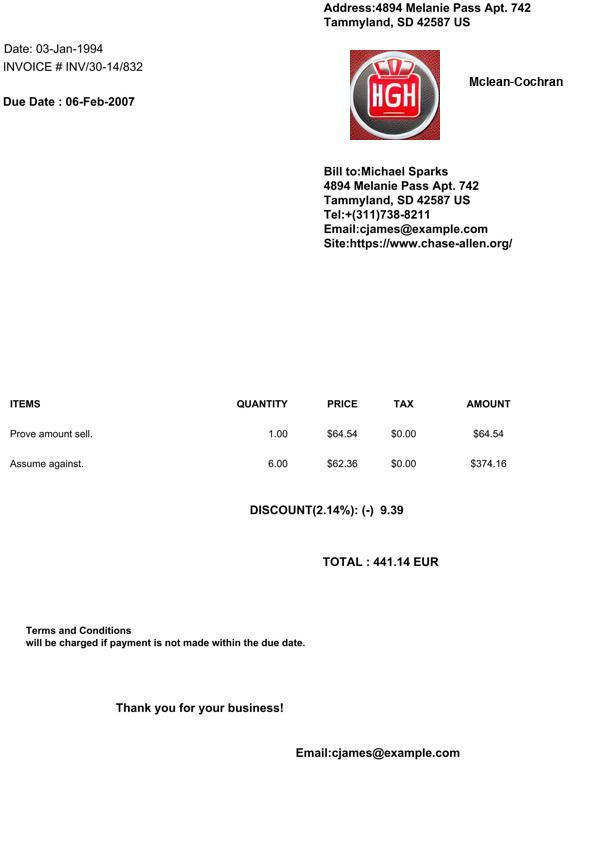

In [8]:
# Show sample image
test_image = invoice_df["test"][0]["image"]
test_image

In [9]:
test_image = invoice_df["test"][0]["image"]

In [10]:
test_pixels = processor(test_image, return_tensors="pt")
test_pixels

{'pixel_values': tensor[1, 3, 224, 224] n=150528 (0.6Mb) x∈[-0.969, 1.000] μ=0.940 σ=0.215}

In [11]:
# test the model
output = ft_model(**test_pixels)
output

ImageClassifierOutput(loss=None, logits=tensor[1, 16] x∈[-0.463, 4.622] μ=0.012 σ=1.253 grad AddmmBackward0, hidden_states=None, attentions=None)

In [12]:
output.logits

tensor[1, 16] x∈[-0.463, 4.622] μ=0.012 σ=1.253 grad AddmmBackward0

In [13]:
output.logits.argmax(dim=-1)

tensor[1] i64 [11]

In [14]:
ft_model.config.id2label[output.logits.argmax(dim=-1).item()]

'invoice'

## Model evaluation

### Pipeline on test example

In [15]:
pipe = pipeline("image-classification", model=ft_model, image_processor=processor, device="cuda")

In [16]:
pipe(test_image, top_k=1)

[{'label': 'invoice', 'score': 0.8977881073951721}]

## Score validation set

In [17]:
results_raw = pipe(invoice_df["validation"]["image"], batch_size=16, top_k=1)

In [18]:
# extract the labels
results = [result[0]["label"] for result in results_raw]
results_int = [0 if result == "invoice" else 1 for result in results]

## Compute metrics

In [19]:
# Load metrics
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])
cfm_metric = evaluate.load("BucketHeadP65/confusion_matrix")

In [20]:
valid_metrics = clf_metrics.compute(references=invoice_df["validation"]["label"], predictions=results_int)
valid_metrics

{'accuracy': 0.93625,
 'f1': 0.9361702127659575,
 'precision': 0.8820754716981132,
 'recall': 0.9973333333333333}

In [21]:
cfm = cfm_metric.compute(references=invoice_df["validation"]["label"], predictions=results_int)["confusion_matrix"]

Confusion matrix, without normalization
[[1500  200]
 [   4 1496]]


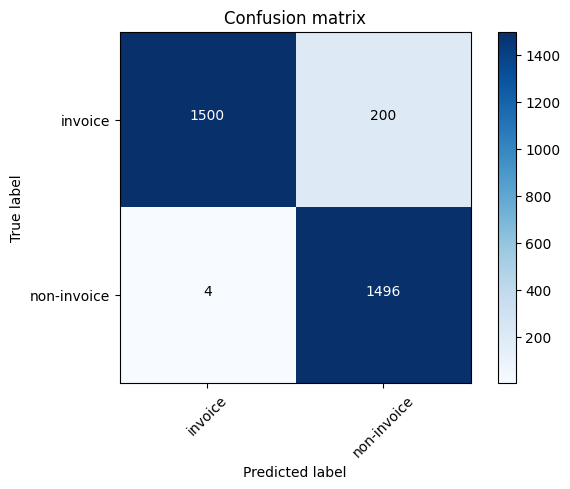

In [32]:
# Visualize non-normalized matrix
cfm_plot = plot_confusion_matrix(cfm, ["invoice", "non-invoice"], normalize=False)

Normalized confusion matrix
[[0.88235294 0.11764706]
 [0.00266667 0.99733333]]


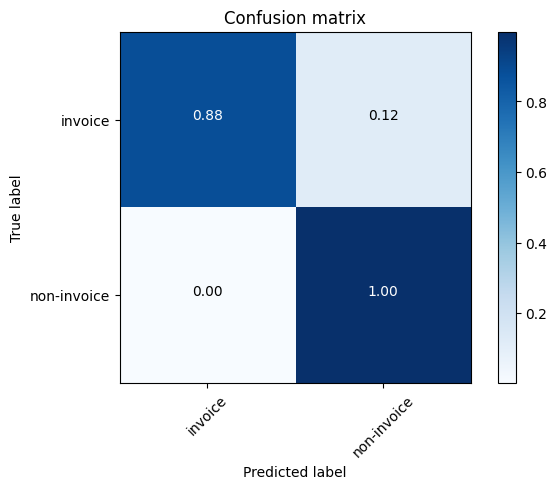

In [33]:
# Visualize normalized matrix
cfm_norm_plot = plot_confusion_matrix(cfm, ["invoice", "non-invoice"], normalize=True)  # Visualize normalized matrix

## Log the results to mlflow
Access the tracking UI by typing `mlflow ui --port 5000` in your console

In [36]:
with mlflow.start_run(run_name=config.models.classification.oob.ft, experiment_id=experiment.experiment_id) as run:
    mlflow.log_metrics(valid_metrics)

    mlflow.log_figure(cfm_plot, "confusion_matrix.png")
    mlflow.log_figure(cfm_norm_plot, "confusion_matrix_normalized.png")